<a href="https://colab.research.google.com/github/Whiner123/Real-Estate-Price-Prediction/blob/main/Real_Estate_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Вступление**

Перед вами стоит задача: построить модель, которая будет предсказывать цену квартиры.

**Легенда**

Вы работаете в компании, которая занимается продажей квартир в Москве и области.

Основная задача компании и её менеджеров — максимально быстро находить выгодные предложения (проще говоря, купить ниже рынка, а продать дороже рынка).

Руководство компании просит вашу команду создать модель, которая будет предсказывать стоимость квартиры по ее характеристикам.

Если такая модель будет работать хорошо, то вы сможете быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены). Это значительно ускорит работу менеджеров и повысит прибыль компании.

Для менеджеров так же разработан отчет в Power BI

**Цели проекта**

* Провести качетсвенную EDA
* Доступно оформить проект
* Провести анализ рынка, достаточный для формирования гипотез
* Добиться высокой метрики MAPE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
import random
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor


In [ ]:
df_p = pd.read_csv('/content/drive/MyDrive/data.csv')
df_p

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,6300000.0,Secondary,Опалиха,6.0,Moscow region,1.0,30.60,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.20,20.0,10.0,6.0,15,European-style renovation
2,11090000.0,Secondary,Мякинино,14.0,Moscow region,1.0,44.70,16.2,13.1,10.0,25,Cosmetic
3,8300000.0,Secondary,Строгино,8.0,Moscow region,1.0,35.10,16.0,11.0,12.0,33,European-style renovation
4,6450000.0,Secondary,Опалиха,6.0,Moscow region,1.0,37.70,15.2,4.0,5.0,5,Without renovation
...,...,...,...,...,...,...,...,...,...,...,...,...
22671,4768792.0,New building,Котельники,8.0,Moscow region,0.0,31.75,13.0,5.0,4.0,17,Cosmetic
22672,5900000.0,New building,Домодедовская,25.0,Moscow region,1.0,31.60,10.1,12.2,11.0,15,Cosmetic
22673,3700000.0,New building,Котельники,30.0,Moscow region,0.0,18.00,15.0,8.1,17.0,17,Cosmetic
22674,5768869.0,New building,Жулебино,14.0,Moscow region,2.0,36.39,22.0,6.6,12.0,14,Cosmetic


In [ ]:
def color_cells(val):
    """ val: значение признака """

    if val == 'float64':
        color = 'red'
    elif val == 'int64':
        color = 'red'
    else:
        color = 'blue'
    return f'color: {color}'
info = pd.DataFrame()
info.index = df_p.columns
info['Тип данных'] = df_p.dtypes
info['Количесвто уникальных'] = df_p.nunique()
info['Количество пропусков'] = df_p.isna().sum()
info['Количество значений'] = df_p.count()
info['%значений'] = round((df_p.count()/ df_p.shape[0]) * 100,2)
info = info.style.applymap(color_cells, subset=['Тип данных'])
info


,Тип данных,Количесвто уникальных,Количество пропусков,Количество значений,%значений
Price,float64,9979,0,22676,100.000000
Apartment type,object,2,0,22676,100.000000
Metro station,object,547,0,22676,100.000000
Minutes to metro,float64,56,0,22676,100.000000
Region,object,2,0,22676,100.000000
Number of rooms,float64,12,0,22676,100.000000
Area,float64,3017,0,22676,100.000000
Living area,float64,1302,0,22676,100.000000
Kitchen area,float64,481,0,22676,100.000000
Floor,float64,72,0,22676,100.000000


In [ ]:
print(f"количество дубликатов: {df_p.duplicated().sum()}")
df_p = df_p.drop_duplicates()
print("форма датасета после удаления дубликатов:", df_p.shape)

количество дубликатов: 1835
форма датасета после удаления дубликатов: (20841, 12)


<Axes: ylabel='Renovation'>

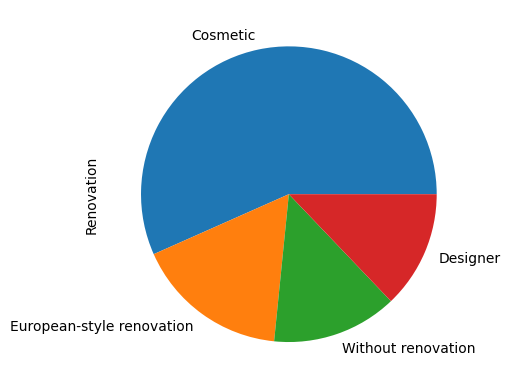

In [ ]:
df_p['Renovation'].value_counts(normalize=True).plot.pie()

<Axes: >

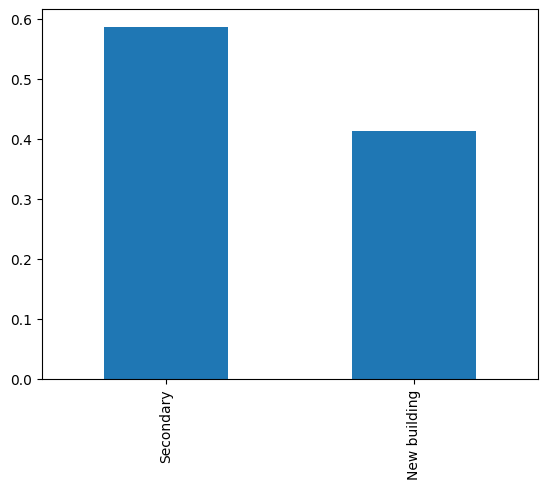

In [ ]:
df_p['Apartment type'].value_counts(normalize=True).plot.bar()

<Axes: >

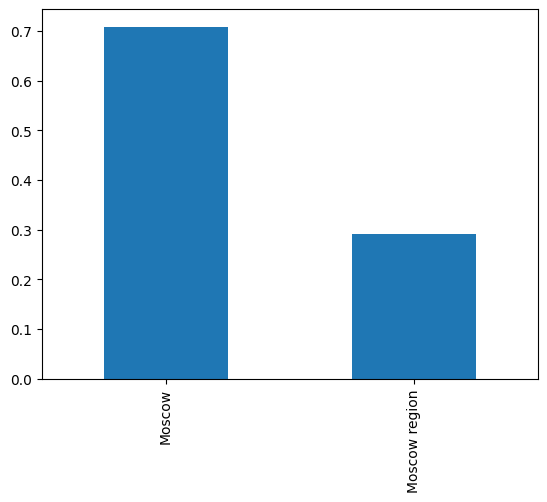

In [ ]:
df_p['Region'].value_counts(normalize=True).plot.bar()

In [ ]:
df_p.rename(columns={'Apartment type': 'Apartment_type', 'Metro station': 'Metro_station'}, inplace=True)
df_p['Apartment_type'] = df_p['Apartment_type'].astype('category')
df_p['Metro_station'] = df_p['Metro_station'].astype('category')
df_p['Region'] = df_p['Region'].astype('category')
df_p['Renovation'] = df_p['Renovation'].astype('category')
df_p['Number of floors'] = df_p['Number of floors'].astype('float64')


<ipython-input-9-a48e7c33832d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p.rename(columns={'Apartment type': 'Apartment_type', 'Metro station': 'Metro_station'}, inplace=True)
<ipython-input-9-a48e7c33832d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['Apartment_type'] = df_p['Apartment_type'].astype('category')
<ipython-input-9-a48e7c33832d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

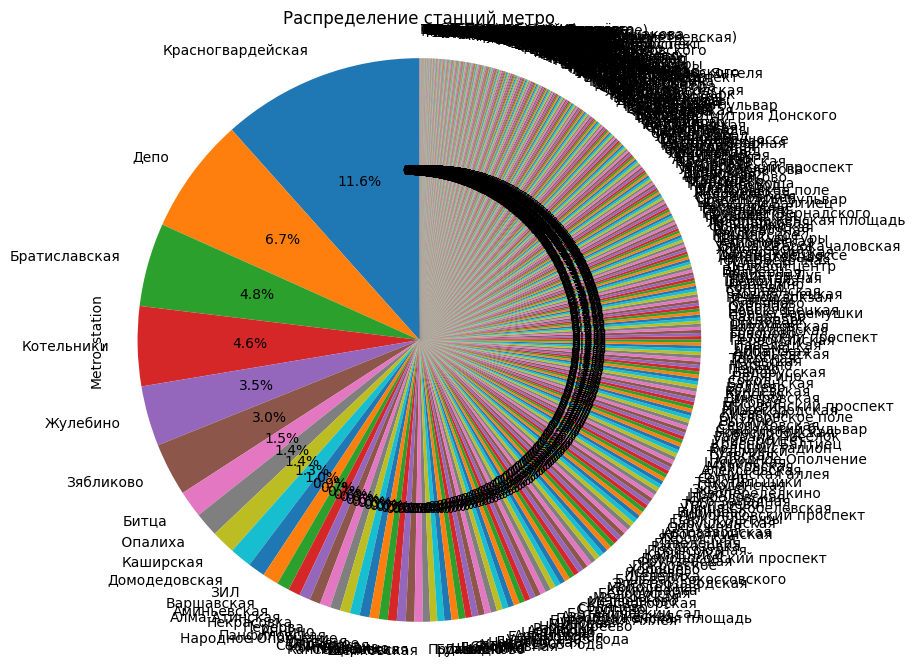

In [ ]:
plt.figure(figsize=(8, 8))
counts = df_p['Metro_station'].value_counts()
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Распределение станций метро')
plt.axis('equal')  # Делает круговую диаграмму круглой
plt.show()

In [ ]:
df_p = pd.get_dummies(df_p, columns=['Apartment_type', 'Region',])
df_p['Renovation'] = df_p['Renovation'].replace('Without renovation', 0)
df_p['Renovation'] = df_p['Renovation'].replace('Cosmetic', 1)
df_p['Renovation'] = df_p['Renovation'].replace('Designer', 2)
df_p['Renovation'] = df_p['Renovation'].replace('European-style renovation', 3)
df_p = df_p.drop(columns=['Metro_station'])

<ipython-input-12-46b62428203e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_p['Price'], label = 'Skewness: %.2f'%(df_p['Price'].skew()))


Text(0.5, 1.0, 'Распределение колонки - Цена')

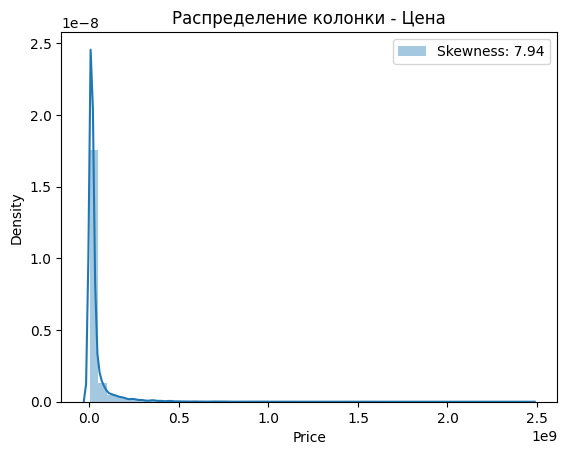

In [ ]:
sns.distplot(df_p['Price'], label = 'Skewness: %.2f'%(df_p['Price'].skew()))
plt.legend(loc = 'best')
plt.title('Распределение колонки - Цена')

<ipython-input-13-64c8eacc877f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_p['Minutes to metro'], label = 'Skewness: %.2f'%(df_p['Minutes to metro'].skew()))


Text(0.5, 1.0, 'Распределение колонки - Минут до метро')

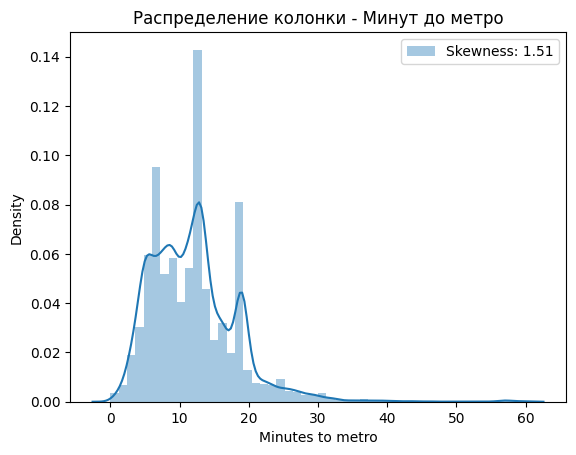

In [ ]:
sns.distplot(df_p['Minutes to metro'], label = 'Skewness: %.2f'%(df_p['Minutes to metro'].skew()))
plt.legend(loc = 'best')
plt.title('Распределение колонки - Минут до метро')

<ipython-input-14-0407a4b5297b>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_p['Number of rooms'], label = 'Skewness: %.2f'%(df_p['Number of rooms'].skew()))


Text(0.5, 1.0, 'Распределение колонки - Количество комнат')

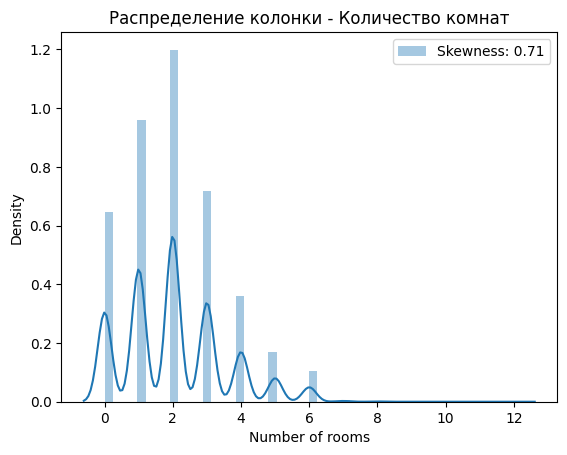

In [ ]:
sns.distplot(df_p['Number of rooms'], label = 'Skewness: %.2f'%(df_p['Number of rooms'].skew()))
plt.legend(loc = 'best')
plt.title('Распределение колонки - Количество комнат')

<ipython-input-15-b6fbc8f071b1>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_p['Area'], label = 'Skewness: %.2f'%(df_p['Area'].skew()))


Text(0.5, 1.0, 'Распределение колонки - Площадь')

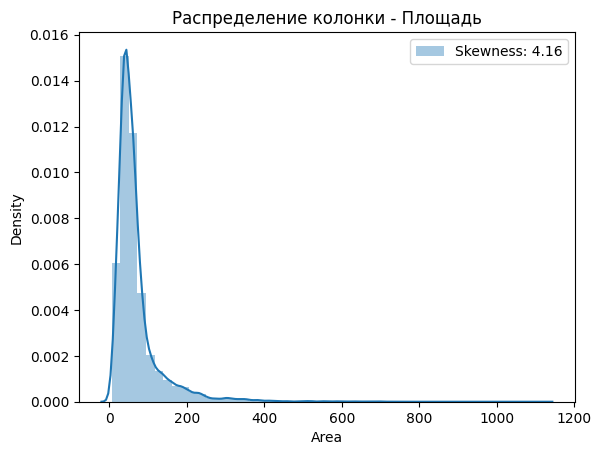

In [ ]:

sns.distplot(df_p['Area'], label = 'Skewness: %.2f'%(df_p['Area'].skew()))
plt.legend(loc = 'best')
plt.title('Распределение колонки - Площадь')

<ipython-input-16-a79bdd1f99c0>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_p['Living area'], label = 'Skewness: %.2f'%(df_p['Living area'].skew()))


Text(0.5, 1.0, 'Распределение колонки - Жилая площадь')

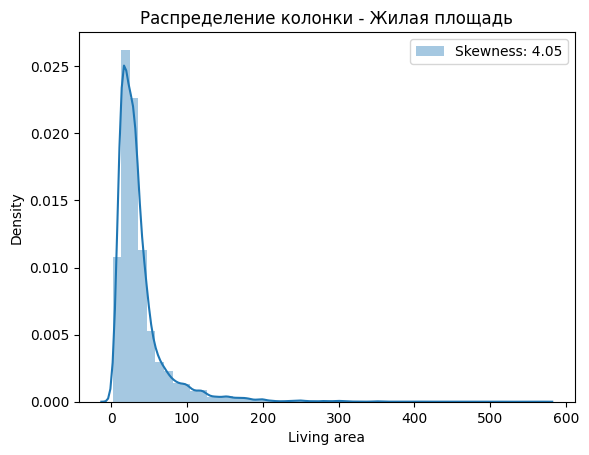

In [ ]:
sns.distplot(df_p['Living area'], label = 'Skewness: %.2f'%(df_p['Living area'].skew()))
plt.legend(loc = 'best')
plt.title('Распределение колонки - Жилая площадь')

<ipython-input-17-4b6aa740b06b>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_p['Kitchen area'], label = 'Skewness: %.2f'%(df_p['Kitchen area'].skew()))


Text(0.5, 1.0, 'Распределение колонки - Площадь кухни')

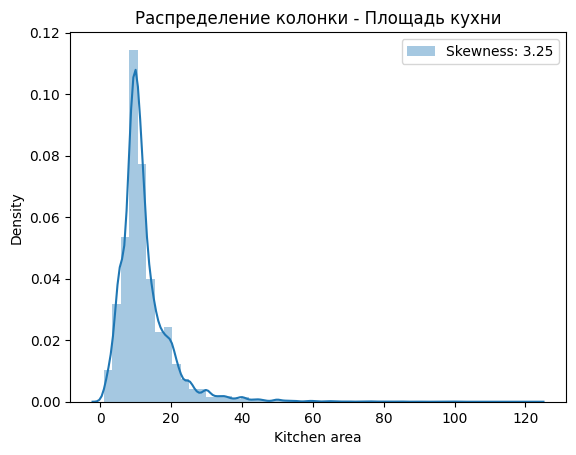

In [ ]:
sns.distplot(df_p['Kitchen area'], label = 'Skewness: %.2f'%(df_p['Kitchen area'].skew()))
plt.legend(loc = 'best')
plt.title('Распределение колонки - Площадь кухни')

<ipython-input-18-1eaa3dca2f31>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_p['Floor'], label = 'Skewness: %.2f'%(df_p['Floor'].skew()))


Text(0.5, 1.0, 'Распределение колонки - количество этажей')

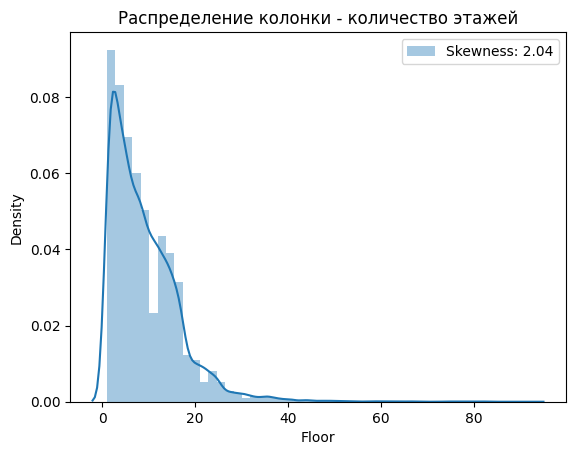

In [ ]:
sns.distplot(df_p['Floor'], label = 'Skewness: %.2f'%(df_p['Floor'].skew()))
plt.legend(loc = 'best')
plt.title('Распределение колонки - количество этажей')

<ipython-input-19-1d07833f8cc4>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_p['Number of floors'], label = 'Skewness: %.2f'%(df_p['Number of floors'].skew()))


Text(0.5, 1.0, 'Распределение колонки - этаж')

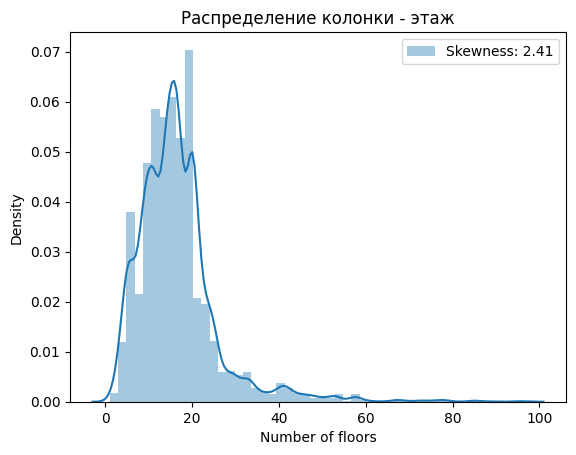

In [ ]:
sns.distplot(df_p['Number of floors'], label = 'Skewness: %.2f'%(df_p['Number of floors'].skew()))
plt.legend(loc = 'best')
plt.title('Распределение колонки - этаж')

In [ ]:
df_check_emission = df_p.select_dtypes('float64')
df_check_emission.describe()

,Price,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors
count,2.084100e+04,20841.000000,20841.000000,20841.000000,20841.000000,20841.000000,20841.000000,20841.000000
mean,3.403777e+07,11.953265,2.039681,69.705636,37.488518,12.421419,9.179358,16.588072
std,7.962198e+07,6.257113,1.487829,64.215736,35.986182,7.539409,7.477360,9.608020
min,1.150000e+06,0.000000,0.000000,6.000000,2.000000,1.000000,1.000000,1.000000
25%,7.089768e+06,7.000000,1.000000,37.160000,17.500000,8.500000,4.000000,11.000000
50%,1.147112e+07,11.000000,2.000000,52.600000,28.400000,10.600000,8.000000,16.000000
75%,2.355000e+07,15.000000,3.000000,75.500000,43.000000,14.300000,13.000000,20.000000
max,2.455020e+09,60.000000,12.000000,1117.000000,566.800000,122.000000,92.000000,97.000000


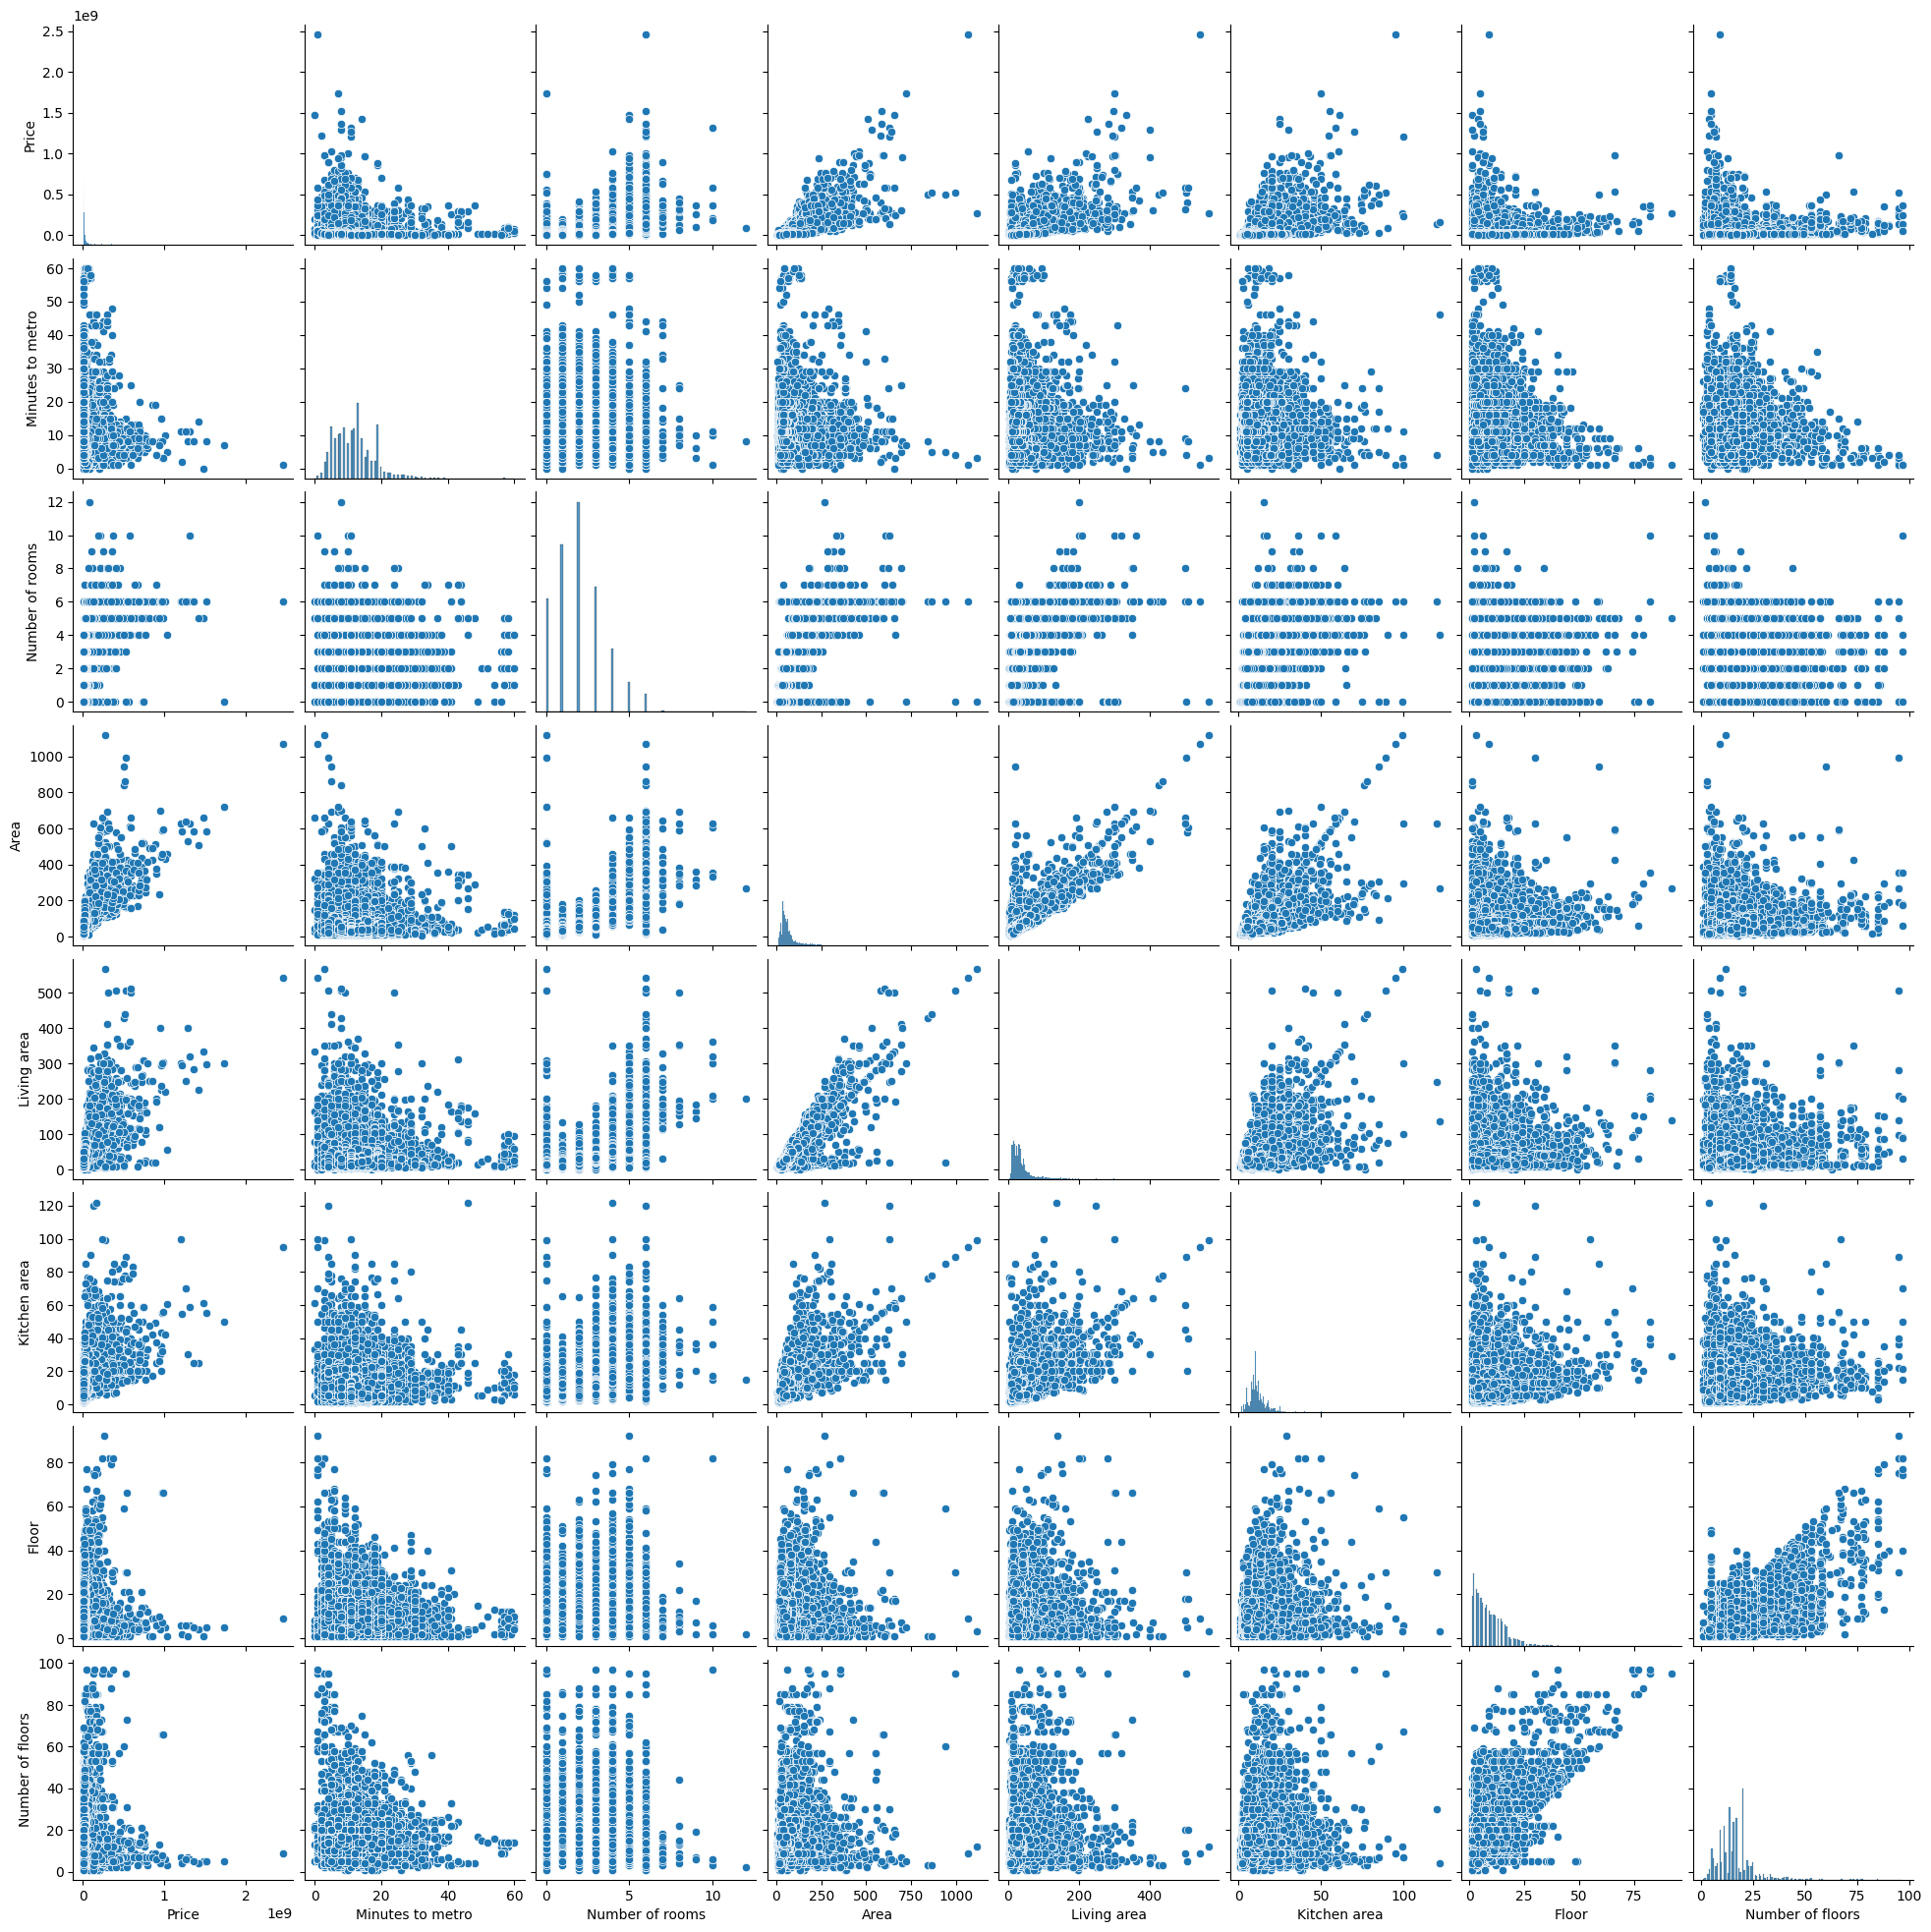

In [ ]:
sns.pairplot(df_check_emission)
plt.show()

In [ ]:
df_std = pd.DataFrame()#Стандартизации
for col in df_check_emission.columns:
  m = df_check_emission[col].mean()
  s = df_check_emission[col].std()
  df_std[col +'_n'] = (df_check_emission[col] - m) /s
df_std.head()
df_std
clustering =  DBSCAN (eps=4, min_samples=3).fit(df_std) #использование кластера DBSCAN
df_std['labels'] = clustering.labels_
df_p[df_std['labels'] == -1]



,Price,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation,Apartment_type_New building,Apartment_type_Secondary,Region_Moscow,Region_Moscow region
643,5.325000e+08,4.0,4.0,426.0,350.0,41.9,66.0,73.0,2,0,1,1,0
933,1.200000e+09,11.0,6.0,630.0,300.0,100.0,6.0,7.0,0,0,1,1,0
1385,2.700000e+08,3.0,0.0,1117.0,566.8,99.1,3.0,12.0,0,0,1,1,0
1416,2.350000e+08,3.0,0.0,353.2,280.0,40.0,82.0,95.0,0,0,1,1,0
1417,5.200000e+08,4.0,0.0,993.6,504.4,88.8,30.0,95.0,0,0,1,1,0
2708,4.000000e+08,8.0,6.0,578.4,504.9,20.0,5.0,5.0,0,0,1,1,0
2709,5.000000e+08,5.0,6.0,941.7,20.0,84.6,59.0,60.0,2,0,1,1,0
3749,2.300000e+08,1.0,4.0,296.0,100.0,100.0,55.0,67.0,2,0,1,1,0
4006,9.703650e+08,3.0,5.0,588.1,299.4,55.3,66.0,66.0,2,0,1,1,0
4007,9.789450e+08,3.0,5.0,593.3,302.1,55.7,66.0,66.0,2,0,1,1,0


<ipython-input-23-ddaf726db807>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_p[column], label='Skewness: %.2f' % (df_p[column].skew()))
<ipython-input-23-ddaf726db807>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_p[column], label='Skewness: %.2f' % (df_p[column].skew()))
<ipython

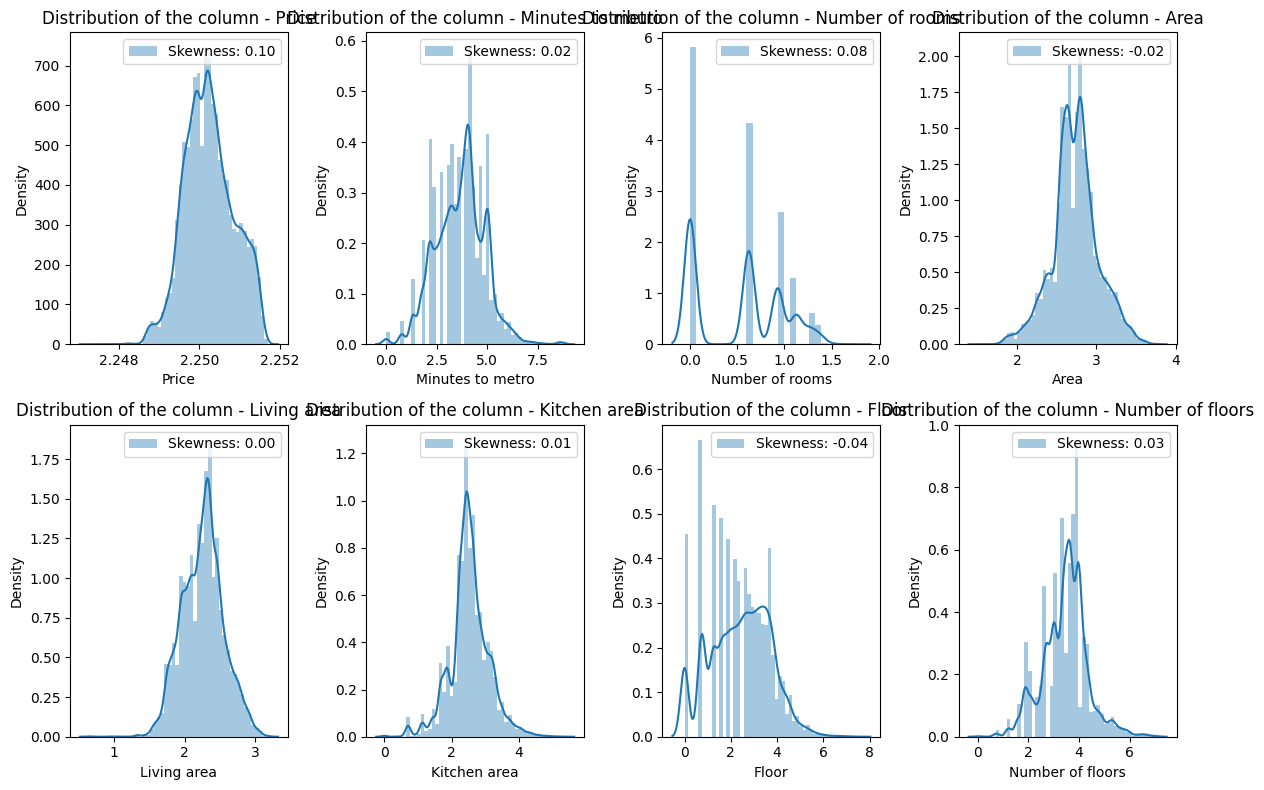

In [ ]:
columns_to_transform = ['Price','Minutes to metro','Number of rooms','Area','Living area', 'Kitchen area','Floor','Number of floors']

for column in columns_to_transform:
    data = [1 if value == 0 else value for value in df_p[column]]
    transformed_data, _ = stats.boxcox(data)
    df_p[column] = transformed_data


plt.figure(figsize=(12, 8))

for i, column in enumerate(columns_to_transform):
    plt.subplot(2, 4, i+1)
    sns.distplot(df_p[column], label='Skewness: %.2f' % (df_p[column].skew()))
    plt.legend(loc='best')
    plt.title(f'Distribution of the column - {column}')

plt.tight_layout()
plt.show()

In [ ]:
def normalize_columns(dataframe, column):
    data = dataframe[column]
    mini = min(data)
    maxi = max(data)

    new_data = []
    for value in data:
        new_data.append((value - mini)/(maxi - mini))

    dataframe[column] = new_data

num_columns = ['Price', 'Minutes to metro', 'Number of rooms', 'Area', 'Living area', 'Kitchen area',
                    'Floor', 'Number of floors', 'Renovation']
for each_column in num_columns:
    normalize_columns(df_p, each_column)

Text(0.5, 1.0, 'Correlation Heatmap')

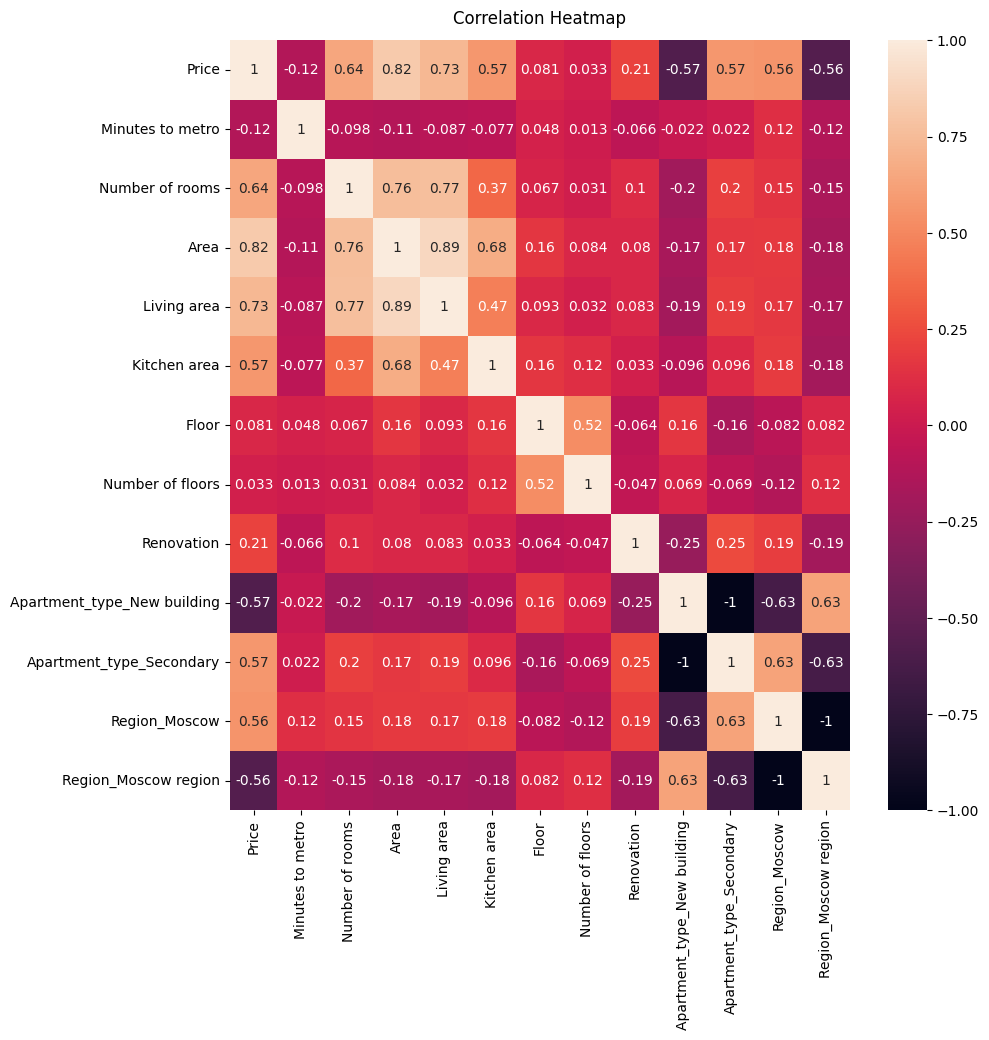

In [ ]:
plt.figure(figsize = (10, 10))
heatmap = sns.heatmap(df_p.corr(), vmin = -1, vmax = 1, annot = True)
heatmap.set_title('Correlation Heatmap', fontdict = {'fontsize' : 12}, pad = 12)

In [ ]:
X = df_p.drop('Price', axis=1)
Y = df_p['Price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 27, shuffle = True)

In [ ]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, Y_train)

LinearRegression()

In [ ]:
Y_pred = linear_regressor.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R^2 Score: {r2}')

Mean Squared Error (MSE): 0.0015412246332439687
Root Mean Squared Error (RMSE): 0.03925843391226869
R^2 Score: 0.9167328991358293


In [ ]:

gradient_boosting_regressor = GradientBoostingRegressor()
gradient_boosting_regressor.fit(X_train, Y_train)
Y_pred = gradient_boosting_regressor.predict(X_test)

In [ ]:
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("Mean Absolute Error:", mae)

Mean Squared Error: 0.0010453125510573836
R^2 Score: 0.9435253344995683
Mean Absolute Error: 0.023938516745188983
